**Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing Skin Cancer Data**
#### Take necessary actions to read the data


In [1]:
#mount google drive
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
# !rm -r "/content/gdrive/MyDrive/Melanoma_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration"

In [3]:
#unzip the dataset
#!unzip "/content/gdrive/MyDrive/Melanoma_Assignment/CNN_assignment.zip" -d "/content/gdrive/MyDrive/Melanoma_Assignment/"


### **Importing all the important libraries**

In [4]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images for Google Colab
#data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
#data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Melanoma_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")



# Defining the path for train and test images for Local Machine
data_dir_train = pathlib.Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
data_dir_train

WindowsPath('CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [7]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Image Count : ",image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Image Count : ",image_count_test)

Train Image Count :  2239
Test Image Count :  118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**

Define some parameters for the loader:

In [8]:
# Create Dataset
# Define some parameters
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9


Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

## Create Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

## Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds).numpy())


Number of training batches: 56
Number of validation batches: 14


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [13]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### **Visualize the data**
#### **Create a code to visualize one instance of all the nine classes present in the dataset**

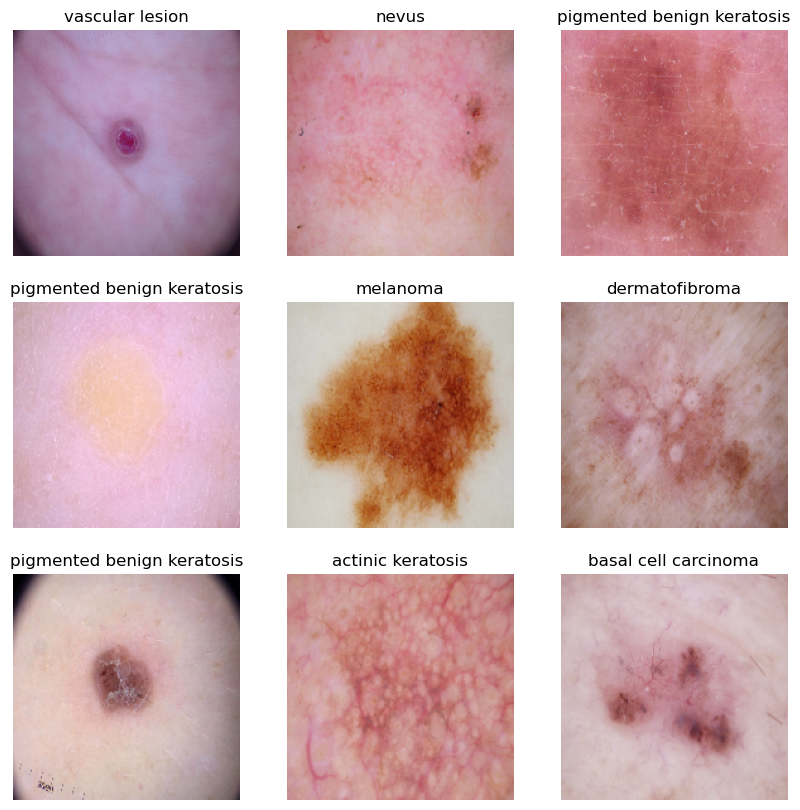

In [14]:
import matplotlib.pyplot as plt
import numpy as np

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # Convert labels to numpy array if necessary
    labels = labels.numpy()

    # Handle case where labels are one-hot encoded
    if labels.ndim > 1 and labels.shape[1] == len(class_names):
        labels = np.argmax(labels, axis=-1)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#!pip show tensorflow

### **Create the model**
 Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D())

#Second Convulation Layer
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D())

#Third Convulation Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D())

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

C:\Users\I520828\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile the model**
Choose an appropirate optimiser and loss function for model training

In [18]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
%%time
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.2786 - loss: 2.0458 - val_accuracy: 0.4251 - val_loss: 1.6361
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.4483 - loss: 1.5508 - val_accuracy: 0.4877 - val_loss: 1.5025
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5209 - loss: 1.3969 - val_accuracy: 0.5034 - val_loss: 1.4137
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5470 - loss: 1.2587 - val_accuracy: 0.5168 - val_loss: 1.3565
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5741 - loss: 1.2320 - val_accuracy: 0.5682 - val_loss: 1.3174
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.6056 - loss: 1.1108 - val_accuracy: 0.5526 - val_loss: 1.3779
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.6234 - loss: 1.0365 - val_accuracy: 0.5548 - val_loss: 1.4876
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.6378 - loss: 0.9977 - val_accuracy: 0.5682

### **Visualizing training results**

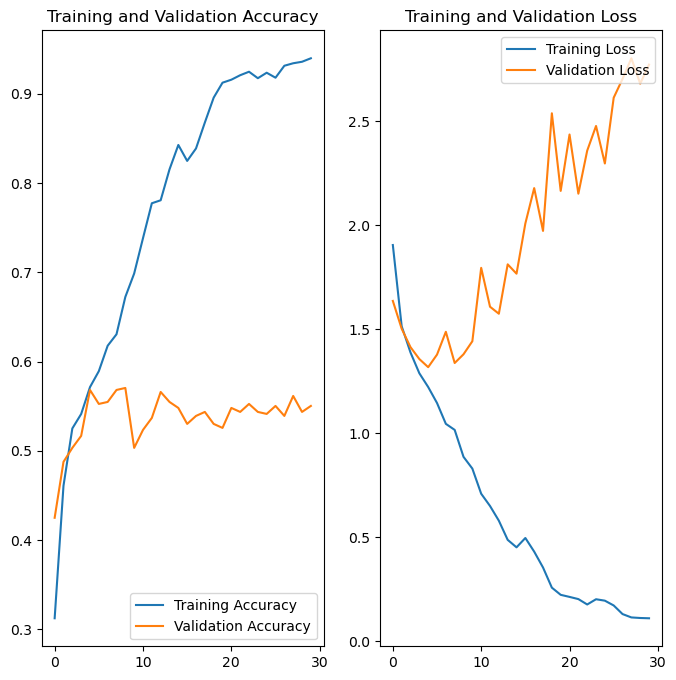

In [20]:
# Plot the training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

**Observations:**


1.   The model's training accuracy shows a steady increase of upto 90%, while validation accuracy remains consistently around 55%.
2.  A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.
3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

In [21]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ])

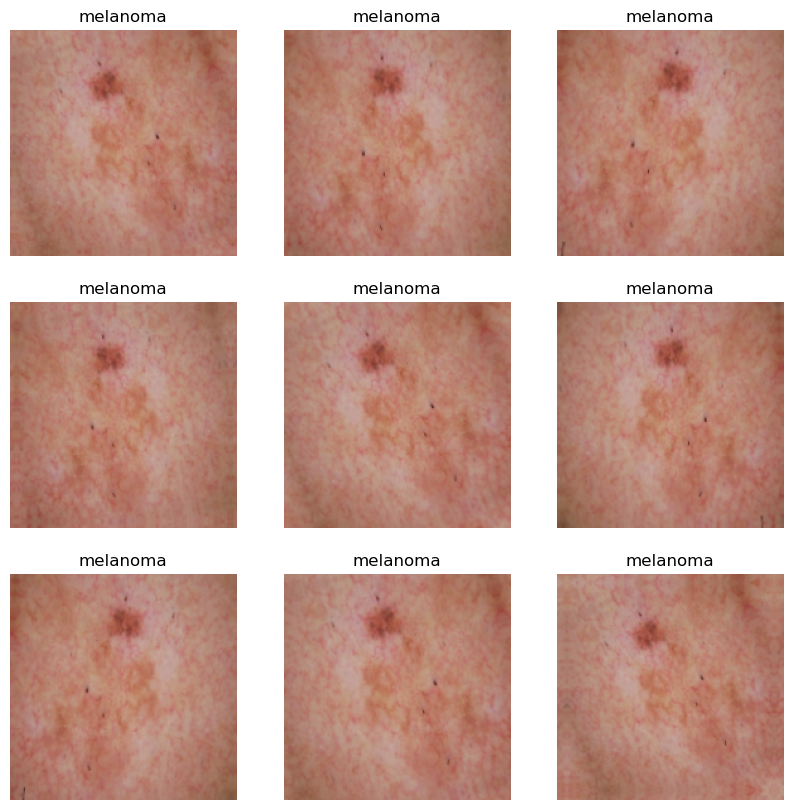

In [22]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        # Convert the label Tensor to a NumPy array and extract the class index
        label_index = np.argmax(labels[0].numpy())
        plt.title(class_names[label_index]) # Index with the integer
        plt.axis("off")

### **Create the model, compile and train the model**

In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax'),
])


In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.2185 - loss: 2.2325 - val_accuracy: 0.2953 - val_loss: 1.8597
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.3260 - loss: 1.8304 - val_accuracy: 0.3356 - val_loss: 1.8137
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.3883 - loss: 1.6905 - val_accuracy: 0.3937 - val_loss: 1.7007
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.3991 - loss: 1.6545 - val_accuracy: 0.4743 - val_loss: 1.4974
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.4725 - loss: 1.4830 - val_accuracy: 0.4787 - val_loss: 1.5047
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.4940 - loss: 1.4366 - val_accuracy: 0.5168 - val_loss: 1.4014
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.5028 - loss: 1.4164 - val_accuracy: 0.5459 - val_loss: 1.3299
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.5200 - loss: 1.3245 - val_accuracy: 0.

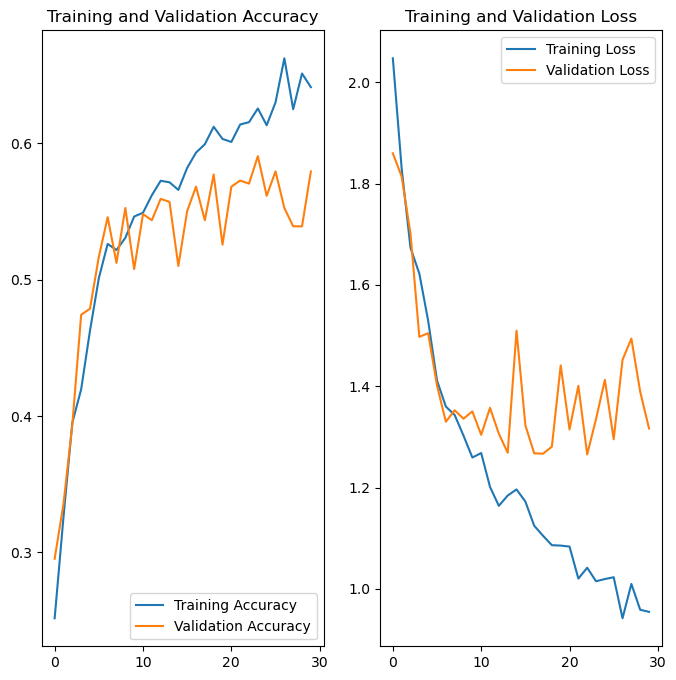

In [26]:
# Plot the training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

**Observations:**

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.


**Find the distribution of classes in the training dataset.**

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [28]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [29]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
1,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
2,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
3,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
4,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis


In [30]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

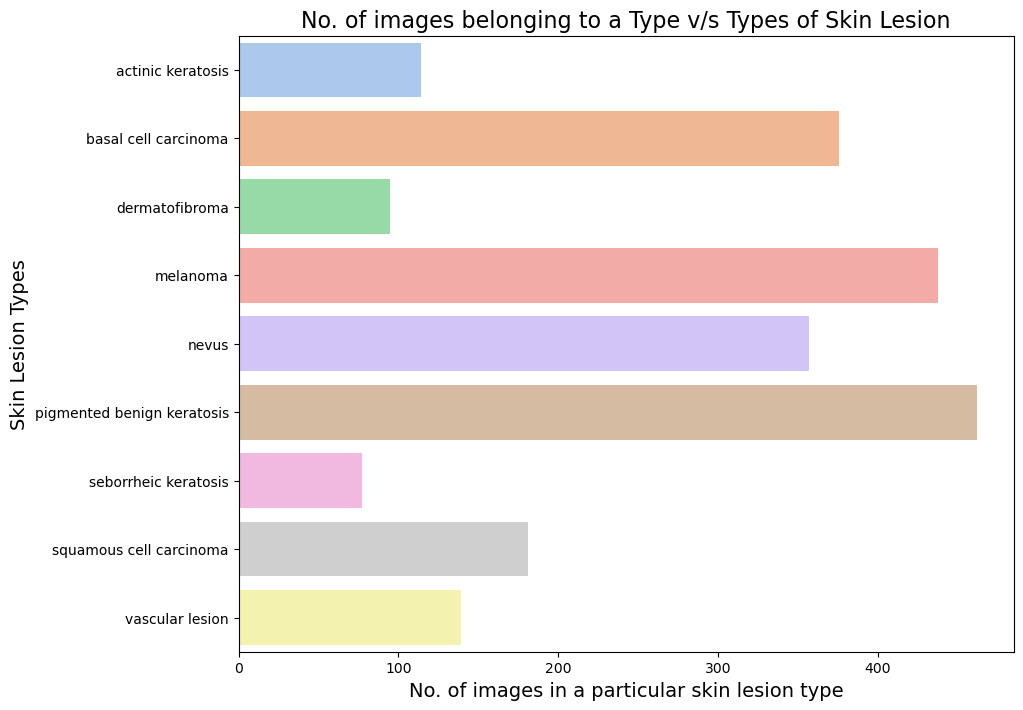

In [31]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette='pastel')
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [32]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

**Write your findings here:**
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

**Observations:**

1. A clear class imbalance is evident within the training data.

2. The class "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately 3.44%.

3. "Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 20.63% and 19.56% of the data, respectively.

**Rectify the class imbalance**

**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [34]:
class_names


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [35]:
path_to_training_dataset = str(data_dir_train) + '\\'

import Augmentor


for class_name in class_names:
    class_dir = data_dir_train / class_name
    output_dir = class_dir / 'output'
    
    # Create the output directory if it does not exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Debugging: Print directory paths
    print(f"Class Directory: {class_dir}")
    print(f"Output Directory: {output_dir}")

    # Ensure directories exist
    if not class_dir.exists():
        print(f"Class directory does not exist: {class_dir}")
        continue
    if not output_dir.exists():
        print(f"Output directory does not exist: {output_dir}")
        continue

    try:
        p = Augmentor.Pipeline(str(class_dir))
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)  # Adding 500 samples per class
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {str(e)}")
    except PermissionError as e:
        print(f"PermissionError: {str(e)}")
    except OSError as e:
        print(f"OSError: {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output
Initialised with 114 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25141C008D0>: 100%|█| 500/500 [00:03<00:00, 165.85 Samples


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output
Initialised with 376 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x25141BEDC90>: 100%|█| 500/500 [00:02<00:


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output
Initialised with 95 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25141BD9310>: 100%|█| 500/500 [00:03<00:00, 143.56 Samples


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output
Initialised with 438 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x251419A3550>: 100%|█| 500/500 [00:17<00:00, 28.82 Sample


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output
Initialised with 357 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=962x722 at 0x250F83CED90>: 100%|█| 500/500 [00:12<00:00, 40.40 Samples/


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output
Initialised with 462 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x250F3A4D150>: 100%|█| 500/500 [00:02<00:00, 210.76 Samples


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output
Initialised with 77 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x25141C008D0>: 100%|█| 500/500 [00:05<00:00, 91.15 Samples


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output
Initialised with 181 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25141BEEE10>: 100%|█| 500/500 [00:02<00:00, 206.73 Samples


Class Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion
Output Directory: CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output
Initialised with 139 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25141B6A610>: 100%|█| 500/500 [00:02<00:00, 194.15 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [37]:
# extracting the augmented image paths in a list
import glob
import os

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list_new[:5]

['CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_02358832-3515-408d-88e0-1826121ab521.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_31f8c6d5-b320-4531-b768-35656ecb5f87.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3d592ed4-875d-4a4c-b727-820080e41e8d.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6b70abd2-dd0e-4b8a-832d-d63ecb4b1c50.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a7b4eb5c-3487-437b-b399-49df18bf9

In [38]:
lesion_list_new = [
    os.path.basename(os.path.dirname(os.path.dirname(y)))
    for y in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))
]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True) # Use pd.concat to combine DataFrames
new_df.shape

(6739, 2)

In [41]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
1,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
2,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
3,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
4,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis


In [42]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [43]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Train the model on the data created using Augmentor**

In [44]:
# Create Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
## Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Create your model (make sure to include normalization)**

In [46]:
# Create Model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax'),
])

# Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [47]:
%%time
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 314ms/step - accuracy: 0.2588 - loss: 3.3397 - val_accuracy: 0.1151 - val_loss: 13.9469
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - accuracy: 0.4027 - loss: 1.5591 - val_accuracy: 0.2123 - val_loss: 7.3653
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 350ms/step - accuracy: 0.4521 - loss: 1.4009 - val_accuracy: 0.3571 - val_loss: 1.9936
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - accuracy: 0.4742 - loss: 1.3516 - val_accuracy: 0.4224 - val_loss: 1.5855
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - accuracy: 0.4874 - loss: 1.2858 - val_accuracy: 0.4900 - val_loss: 1.3481
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 345ms/step - accuracy: 0.5013 - loss: 1.2361 - val_accuracy: 0.4484 - val_loss: 1.5098
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - accuracy: 0.5090 - loss: 1.2221 - val_accuracy: 0.5130 - val_loss: 1.2910
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - accuracy: 0.5288 - loss: 

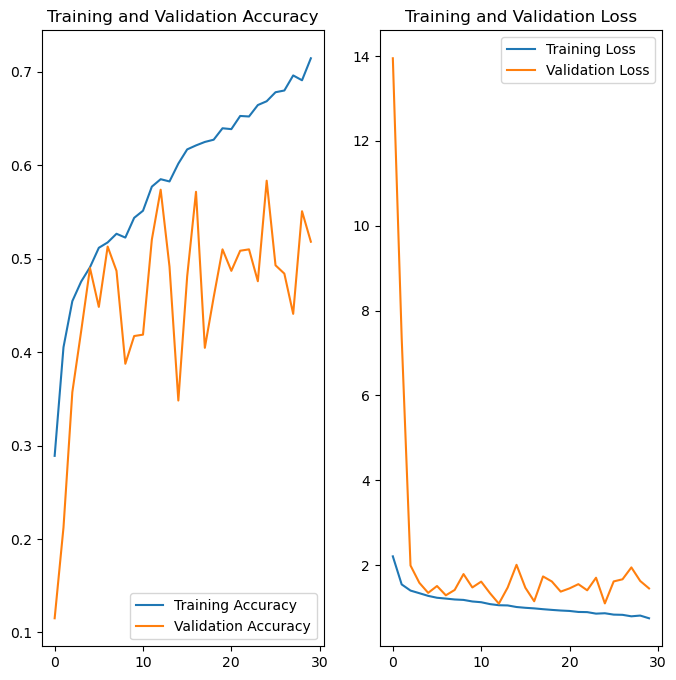

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1. Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

#### **Creating another model (without batch normalization)**

In [49]:
# Create Model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
])

# Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [51]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2197 - loss: 2.0720
Epoch 1: val_accuracy improved from -inf to 0.30364, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - accuracy: 0.2201 - loss: 2.0707 - val_accuracy: 0.3036 - val_loss: 2.0140
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4158 - loss: 1.5633
Epoch 2: val_accuracy improved from 0.30364 to 0.48998, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.4159 - loss: 1.5629 - val_accuracy: 0.4900 - val_loss: 1.4008
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4718 - loss: 1.4022
Epoch 3: val_accuracy improved from 0.48998 to 0.49369, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.4718 - loss: 1.4021 - val_accuracy: 0.4937 - val_loss: 1.3456
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5059 - loss: 1.2992
Epoch 4: val_accuracy improved from 0.4

169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.7751 - loss: 0.6039 - val_accuracy: 0.7461 - val_loss: 0.7357
Epoch 25/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7919 - loss: 0.5704
Epoch 25: val_accuracy did not improve from 0.74833
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.7918 - loss: 0.5704 - val_accuracy: 0.7409 - val_loss: 0.7185
Epoch 26/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7747 - loss: 0.5867
Epoch 26: val_accuracy did not improve from 0.74833
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.7748 - loss: 0.5866 - val_accuracy: 0.7387 - val_loss: 0.7122
Epoch 27/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8014 - loss: 0.5259
Epoch 27: val_accuracy improved from 0.74833 to 0.76689, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.8014 - loss: 0.5260 - val_accuracy: 0.7669 - val_loss: 0.6427
Epoch 28/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accurac

In [52]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

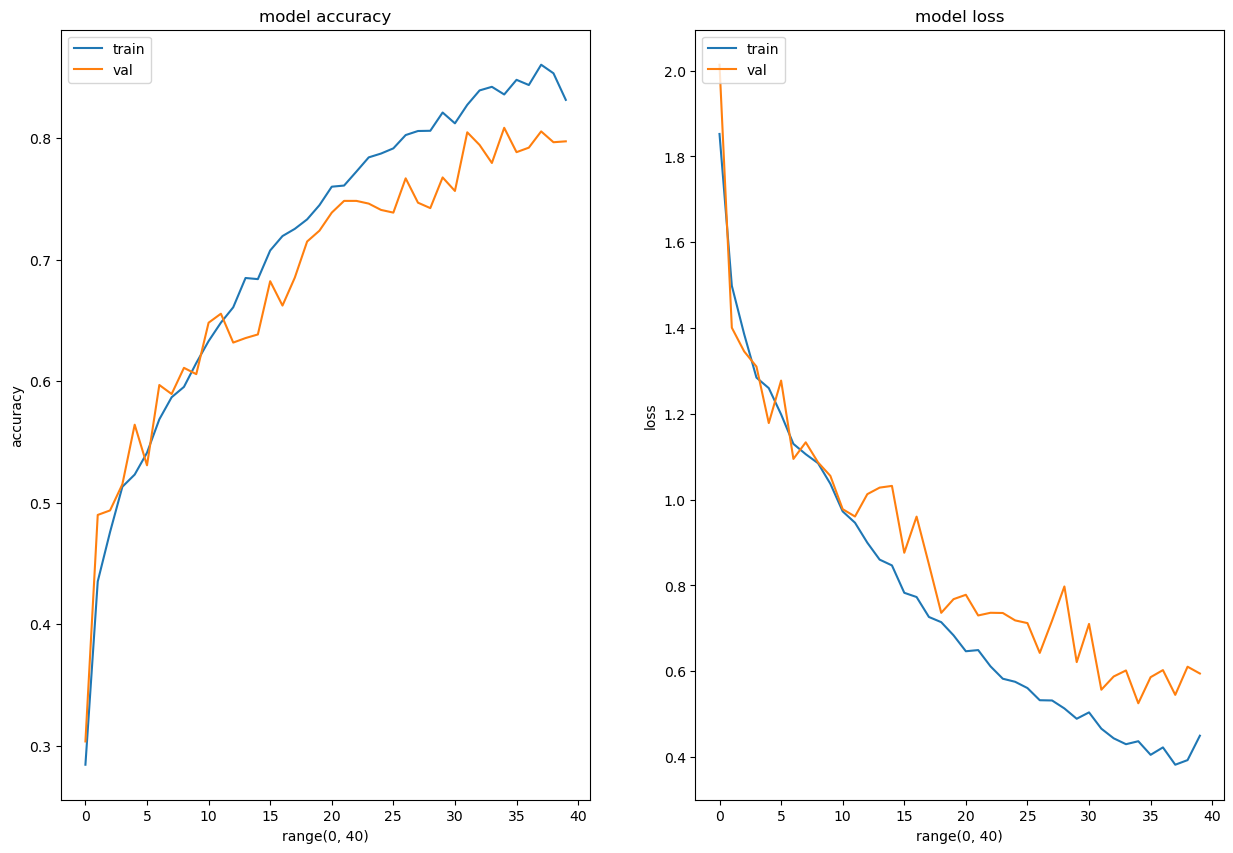

In [53]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

**Observations:**

1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3. Following 40 epochs, the final model attains an accuracy of 82.99% on the training set and approximately 79.73% on the validation set.

4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

5. The addition of batch normalization failed to enhance both training and validation accuracy.

### **Model Evaluation**

One of the instance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Actual Class: vascular lesion
Predicted Class: vascular lesion


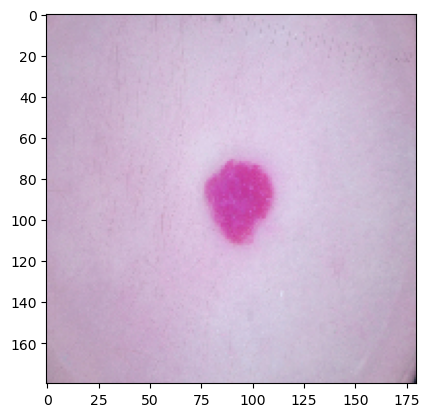

In [54]:
# Evaluating our model on one of the instances in the test set
from glob import glob
from tensorflow.keras.preprocessing.image import load_img


print("One of the instance")
image_path_test = os.path.join(data_dir_test, class_names[8], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[8] +'\n'+ "Predicted Class: " + predicted_class)



One of the other instance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class: squamous cell carcinoma
Predicted Class: squamous cell carcinoma


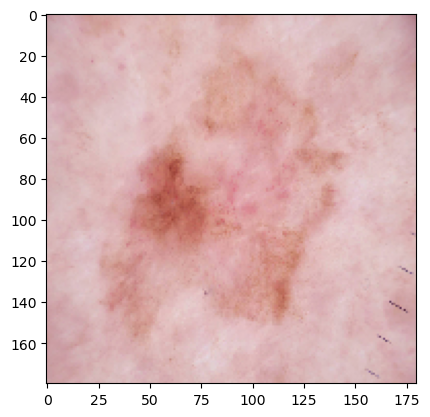

In [55]:
print("One of the other instance")
image_path_test = os.path.join(data_dir_test, class_names[7], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[7] +'\n'+ "Predicted Class: " + predicted_class)